In [974]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from sklearn.linear_model import LogisticRegression

## create dataset

In [2]:
PATH='data/aclImdb/'
names = ['neg','pos']
names1 = ['neg', 'pos_']
names2 = ['neg_', 'pos']

In [3]:
! ls {PATH}train

labeledBow.feat pos             unsupBow.feat   urls_pos.txt
neg             unsup           urls_neg.txt    urls_unsup.txt


In [4]:
trn1,trn1_y = texts_labels_from_folders(f'{PATH}train',names1)
val1,val1_y = texts_labels_from_folders(f'{PATH}test',names1)

In [5]:
trn2,trn2_y = texts_labels_from_folders(f'{PATH}train',names2)
val2,val2_y = texts_labels_from_folders(f'{PATH}test',names2)

In [6]:
len(trn1), len(trn1_y), len(trn2), len(trn2_y)

(12500, 12500, 12500, 12500)

In [7]:
assert (trn1_y==0).all()
(trn1_y==0).all()

True

In [8]:
assert (trn1_y==0).all()
(val1_y==0).all()

True

In [9]:
assert (trn2_y==1).all()
(trn2_y==1).all()

True

In [10]:
assert (val2_y==1).all()
(val2_y==1).all()

True

In [11]:
def sample_util(data, label, n):
    assert len(data) == label.shape[0]
    idx = np.random.choice(range(len(data)),n)
    data_new = [data[i] for i in idx]
    label_new = label[idx]
    return data_new, label_new

In [12]:
def sample(data1, label1, data2, label2, n):
    t1, t2 = sample_util(data1, label1, n)
    t3, t4 = sample_util(data2, label2, n)
    data = t1 + t3
    label = np.concatenate((t2, t4))
    return data, label

In [1172]:
# trn, trn_y = sample(trn1, trn1_y, trn2, trn2_y, 64*10)
# val, val_y = sample(val1, val1_y, val2, val2_y, 64*20)

In [1173]:
trn,trn_y = texts_labels_from_folders(f'{PATH}train',names)
val,val_y = texts_labels_from_folders(f'{PATH}test',names)

## create vectors and vocab

In [1174]:
veczr = CountVectorizer(tokenizer=tokenize)

In [1175]:
trn_term_doc = veczr.fit_transform(trn)

In [1176]:
val_term_doc = veczr.transform(val)

In [1177]:
vocab = veczr.get_feature_names(); vocab[5000:5005]

['aussie', 'aussies', 'austen', 'austeniana', 'austens']

In [1178]:
vocab[:5]

['\x08\x08\x08\x08a', '\x10own', '!', '"', '#']

In [1179]:
len(vocab)

75132

In [1180]:
trn_term_doc = trn_term_doc.sign()

In [1181]:
val_term_doc = val_term_doc.sign()

## Naive Bayes

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [1182]:
def pr(y_i):
    p = x[y==y_i].sum(0)
    return p+1

In [1183]:
x=trn_term_doc
y=trn_y

p = pr(1)/pr(1).sum()
q = pr(0)/pr(0).sum()
r = np.log(p/q)
b = np.log((y==1).mean() / (y==0).mean())

In [1184]:
val_term_doc.shape

(25000, 75132)

In [1185]:
val_term_doc.shape[1]

75132

In [1186]:
x.shape

(25000, 75132)

In [1187]:
r.shape

(1, 75132)

In [1188]:
(val_term_doc @ r.T).shape

(25000, 1)

In [1189]:
val_term_doc @ r.T

matrix([[-5.25616],
        [-3.41848],
        [ 0.42768],
        ...,
        [68.81967],
        [ 4.6196 ],
        [ 3.74532]])

In [1190]:
val_y

array([0, 0, 0, ..., 1, 1, 1])

In [1191]:
pre_preds = val_term_doc @ r.T + b
preds = pre_preds.T>0
(preds==val_y).mean()

0.82844

In [1192]:
pre_preds = val_term_doc @ np.stack([np.log(p), np.log(q)]).T + b

In [1193]:
pre_preds

matrix([[ -617.48225,  -612.22609],
        [ -549.41436,  -545.99589],
        [-1036.89288, -1037.32056],
        ...,
        [-4026.31409, -4095.13376],
        [ -633.7084 ,  -638.328  ],
        [ -508.107  ,  -511.85232]])

In [1194]:
preds = pre_preds.T[0] > pre_preds.T[1]
(preds==val_y).mean()

0.82844

In [2335]:
type(val_term_doc)

scipy.sparse.csr.csr_matrix

In [2336]:
val_term_doc[0]

<1x75132 sparse matrix of type '<class 'numpy.int64'>'
	with 83 stored elements in Compressed Sparse Row format>

In [2339]:
xx = val_term_doc[0]

In [2345]:
[vocab[index] for index, i in enumerate(xx.toarray()[0]) if i > 0]

['&',
 "'",
 ',',
 '-',
 '.',
 '/',
 'a',
 'accents',
 'actors',
 'alan',
 'and',
 'as',
 'been',
 'but',
 'by',
 'cluttered',
 'could',
 'detective',
 'emma',
 'entertain',
 'entertaining',
 'fact',
 'film',
 'flick',
 'for',
 'gets',
 'give',
 'good',
 'hal',
 'have',
 'holbrook',
 'if',
 'impression',
 'in',
 'is',
 'it',
 'kidnappers',
 'matter',
 'more',
 'mostly',
 'movie',
 'muddles',
 'new',
 'no',
 'not',
 'nothing',
 'off',
 'one',
 'orleans',
 'performances',
 'plot',
 'potential',
 'pulled',
 'rather',
 'really',
 'rickman',
 's',
 'scene',
 'scenes',
 'seeing',
 'seems',
 'shows',
 'southern',
 'subplot',
 'than',
 'that',
 'the',
 'their',
 'these',
 'things',
 'this',
 'thompson',
 'three',
 'to',
 'uninteresting',
 'us',
 'view',
 'was',
 'watching',
 'well',
 'what',
 'with',
 'worth']

## Logistic regression (sklearn)

Here is how we can fit logistic regression where the features are the unigrams.

In [ ]:
LogisticRegression

In [ ]:
m = LogisticRegression(C=1e8, dual=False, max_iter=1000)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

...and the regularized version

In [ ]:
m = LogisticRegression(C=0.1, dual=False, max_iter=1000)
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

## Logistic regression (PyTorch)

In [1195]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.nlp import *

import torch.nn as nn

In [2332]:
class MySimpleNB(nn.Module):
    def __init__(self, nf, ny):
        super().__init__()
        self.w = nn.Embedding(nf, ny)
        # self.w = nn.Embedding(nf+1, ny)
        # self.w.weight.data.uniform_(-1, 1)
        self.w.weight.data = torch.FloatTensor(r.tolist()[0])
        self.w.weight.data = self.w.weight.data.reshape(-1, 1)
        # self.r = nn.Embedding(nf, ny)
        
    def forward(self, feat_idx):
        # self.w.weight.data[0] = 0
        idx = feat_idx - 1
        idx2 = [a for a in idx if a >= 0]
        idx3 = np.array(idx2)
        v = self.w(V(idx3))
        # r = self.r(feat_idx)
        # x = ((w+self.w_adj)*r/self.r_adj).sum(1)
        # x = w*r
        x = v.sum(1)
        # return F.softmax(x)
        # return x.reshape(1, -1)
        return x

In [2330]:
def binary_loss(pred, y):
    # y2 = torch.max(y,axis=1)[0]
    y2 = np.argmax(y)
    p = torch.exp(pred) / (1+torch.exp(pred))
    result = torch.mean(-(y2 * torch.log(p) + (1-y2)*torch.log(1-p)))
    # return result.reshape(1, -1)
    return result

In [2305]:
r.shape

(1, 75132)

In [2301]:
len(vocab)

75132

In [2296]:
net3 = MySimpleNB(len(vocab), 1)

In [2297]:
net2.w.weight.data.shape

torch.Size([75132, 1])

In [2225]:
r.shape

(1, 75132)

In [2226]:
xx = torch.FloatTensor([0] + r.tolist()[0]).reshape(-1, 1)

In [2227]:
xx.shape

torch.Size([75133, 1])

In [2228]:
t

(array([64760, 65310, 66442, 66459, 66496, 66555, 66685, 66822, 67028, 67253, 67489, 68750, 69789, 72338,
        72480, 72746, 72897, 73767, 73992, 74479]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 20,
 array([1., 0.], dtype=float32))

In [2229]:
for xx in t[0]:
    print(vocab[xx-1])

surprisingly
t
that
the
them
there
this
through
tilly
to
top
turned
unger
was
way
were
when
work
written
you


In [2230]:
net3.w

Embedding(75132, 1)

In [2231]:
net3.w.weight.data[0]

tensor([0.6904])

In [2232]:
net3.w.weight.data.shape

torch.Size([75132, 1])

In [2233]:
embedding = nn.Embedding(10, 1)

In [2234]:
input = torch.LongTensor([[1,2,4,0],[4,3,2,9]])

In [2235]:
embedding(input)

tensor([[[-0.3559],
         [-0.1087],
         [ 1.4720],
         [-1.3244]],

        [[ 1.4720],
         [ 0.3285],
         [-0.1087],
         [-0.5361]]], grad_fn=<EmbeddingBackward>)

In [2236]:
embedding(input).sum(1)

tensor([[-0.3169],
        [ 1.1557]], grad_fn=<SumBackward1>)

In [2237]:
sl=val_term_doc.shape[1]
sl

75132

In [2421]:
sl=val_term_doc.shape[1]
md = TextClassifierData.from_bow(
    trn_term_doc, trn_y,
    val_term_doc, val_y,
    100,
)

In [2422]:
# ??TextClassifierData.from_bow

In [2348]:
trn_term_doc.shape

(25000, 75132)

In [2349]:
i=0

In [2350]:
net4 = MySimpleNB(len(vocab), 1)
# loss = nn.NLLLoss()
# loss = torch.nn.CrossEntropyLoss()
loss = binary_loss
lr = 1e-2
losses=[]

In [2351]:
net4.w.weight

Parameter containing:
tensor([[ 0.6904],
        [-0.6959],
        [-0.0575],
        ...,
        [ 0.6904],
        [-0.0028],
        [-0.6959]], requires_grad=True)

In [2352]:
ii=2

In [2353]:
t = md.trn_ds[ii]
ii = ii + 1
xt, _a, _b, yt = t

In [2354]:
t

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     3,     9,    14,    16,  1051,  1610,  2420,  2620,  2727,
         2853,  3055,  3124,  3220,  3478,  4722,  5222,  6179,  7457,  7608,  9855, 11613, 16117, 16844,
        16909, 18298, 18573, 18634, 19322, 194

In [2355]:
xt.shape, len(vocab)

((200,), 75132)

In [2356]:
xt.shape

(200,)

In [2359]:
xt = xt.reshape(1, 200)

In [2360]:
xt.shape

(1, 200)

In [2361]:
vocab[18178], len(vocab)

('diagnoses', 75132)

In [2362]:
_a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [2363]:
_a.sum()

97

In [2364]:
_b

97

In [2365]:
yt

array([1., 0.], dtype=float32)

In [2366]:
md.trn_ds[ii]

(array([ 3220,  3478,  3669,  3808,  4091,  4432,  4722,  5370,  5406,  6305,  6520,  7013,  7230,  7326,
         7608,  7965,  8026,  8485,  8573,  8697,  9007,  9855,  9937, 10255, 10334, 10380, 10458, 10566,
        10870, 10931, 11666, 11777, 11783, 11788, 12021, 15045, 15123, 15126, 15343, 16560, 17158, 17869,
        18298, 19351, 19389, 19417, 19849, 20580, 20690, 20717, 21765, 21790, 22719, 22738, 22882, 23125,
        23947, 24625, 25361, 25458, 25578, 26106, 26189, 27330, 27582, 27977, 28068, 28399, 29252, 29387,
        29791, 29803, 29809, 30136, 30149, 30229, 30665, 31121, 31885, 32222, 32392, 32548, 32804, 32936,
        33037, 34617, 34677, 34717, 35822, 36290, 36742, 36953, 38725, 39099, 39403, 40878, 41400, 41885,
        41895, 43025, 43892, 44203, 44220, 44304, 44626, 44705, 45055, 45496, 45509, 46118, 46220, 46750,
        46769, 46783, 46829, 46869, 46987, 47003, 47031, 47216, 47482, 47524, 48815, 50669, 50732, 51422,
        51486, 51882, 52569, 53875, 53937, 547

In [2367]:
xt.shape

(1, 200)

In [2368]:
for index, idx in enumerate(to_np(xt[0])):
    if idx:
        print(vocab[idx-1])

!
'
,
.
a
actors
alan
all
almost
always
among
amusing
and
annoying
at
away
bates
bit
blame
but
characters
cute
deborah
decent
didn
director
disappoint
do
does
from
goes
going
good
gotta
hard
has
have
he
hell
here
i
if
in
is
it
jennifer
john
kara
know
make
material
matthew
modine
movie
neville
not
ok
one
others
ouch
outrageous
over
painful
parts
pedestrian
performances
played
possible
premise
re
run
s
schlock
screaming
script
sit
such
surprisingly
t
that
the
them
there
this
through
tilly
to
top
turned
unger
was
way
were
when
work
written
you


In [2369]:
vocab[0], len(vocab)

('\x08\x08\x08\x08a', 75132)

In [2370]:
xt

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     3,     9,    14,    16,  1051,  1610,  2420,  2620,  2727,
         2853,  3055,  3124,  3220,  3478,  4722,  5222,  6179,  7457,  7608,  9855, 11613, 16117, 16844,
        16909, 18298, 18573, 18634, 19322, 194

In [2371]:
net4.w(V(xt)).sum()

tensor(55.0210, grad_fn=<SumBackward0>)

In [2372]:
xt.shape

(1, 200)

In [2377]:
xt.shape

(1, 200)

In [2378]:
y_pred = net4(V(xt[0]))
print(y_pred)
l = binary_loss(y_pred, yt)

tensor([-5.7479e-02, -4.1577e-02, -9.9442e-03, -3.4373e-03, -5.4424e-03,
        -1.7379e-01,  4.3313e-01, -1.8541e-02, -1.2916e-03,  5.5653e-01,
         4.7712e-01, -1.1129e-02,  8.4602e-03, -1.2968e+00, -8.2108e-02,
        -1.1287e-01,  5.4082e-01,  2.6922e-01, -1.1351e+00, -5.3193e-02,
        -1.9695e-02,  1.0134e-01, -3.6570e-01, -8.8736e-01, -4.2275e-01,
        -1.2697e-01,  7.9732e-01, -2.4320e-01,  5.2103e-02,  2.9463e-02,
        -4.4487e-02, -2.5613e-01, -1.9596e-02, -4.2846e-01, -6.5210e-02,
         1.1156e-01, -1.2319e-01,  6.2853e-02, -6.1823e-01, -1.2425e-01,
        -7.9586e-02, -1.9558e-01,  1.2358e-02,  2.1014e-02, -1.2308e-02,
        -1.3063e-01,  4.5022e-01, -1.2068e+00, -1.2334e-01, -3.1028e-01,
        -2.9966e-01,  2.5392e-01, -2.5411e-01, -1.6408e-01,  1.2500e+00,
        -1.1374e-01, -7.6541e-01,  1.3722e-02,  3.2920e-01, -1.1014e+00,
         1.0075e-01, -8.0419e-02, -1.0222e+00,  1.6660e-01, -1.1755e+00,
         7.0972e-01,  3.5182e-01, -2.4431e-01, -7.7

In [2379]:
y_pred

tensor([-5.7479e-02, -4.1577e-02, -9.9442e-03, -3.4373e-03, -5.4424e-03,
        -1.7379e-01,  4.3313e-01, -1.8541e-02, -1.2916e-03,  5.5653e-01,
         4.7712e-01, -1.1129e-02,  8.4602e-03, -1.2968e+00, -8.2108e-02,
        -1.1287e-01,  5.4082e-01,  2.6922e-01, -1.1351e+00, -5.3193e-02,
        -1.9695e-02,  1.0134e-01, -3.6570e-01, -8.8736e-01, -4.2275e-01,
        -1.2697e-01,  7.9732e-01, -2.4320e-01,  5.2103e-02,  2.9463e-02,
        -4.4487e-02, -2.5613e-01, -1.9596e-02, -4.2846e-01, -6.5210e-02,
         1.1156e-01, -1.2319e-01,  6.2853e-02, -6.1823e-01, -1.2425e-01,
        -7.9586e-02, -1.9558e-01,  1.2358e-02,  2.1014e-02, -1.2308e-02,
        -1.3063e-01,  4.5022e-01, -1.2068e+00, -1.2334e-01, -3.1028e-01,
        -2.9966e-01,  2.5392e-01, -2.5411e-01, -1.6408e-01,  1.2500e+00,
        -1.1374e-01, -7.6541e-01,  1.3722e-02,  3.2920e-01, -1.1014e+00,
         1.0075e-01, -8.0419e-02, -1.0222e+00,  1.6660e-01, -1.1755e+00,
         7.0972e-01,  3.5182e-01, -2.4431e-01, -7.7

In [2380]:
print(net4.w.weight.grad)

None


In [2381]:
l.shape

torch.Size([])

In [2382]:
l.backward()

In [2383]:
_a.shape, _a

((200,),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [2384]:
for idx, i in enumerate(net4.w.weight.grad.data):
    for j in i:
        if j != 0:
            print(idx, j, net4.w.weight.data[idx])

2 tensor(0.0050) tensor([-0.0575])
8 tensor(0.0050) tensor([-0.0416])
13 tensor(0.0051) tensor([-0.0099])
15 tensor(0.0051) tensor([-0.0034])
1050 tensor(0.0051) tensor([-0.0054])
1609 tensor(0.0047) tensor([-0.1738])
2419 tensor(0.0063) tensor([0.4331])
2619 tensor(0.0051) tensor([-0.0185])
2726 tensor(0.0052) tensor([-0.0013])
2852 tensor(0.0066) tensor([0.5565])
3054 tensor(0.0064) tensor([0.4771])
3123 tensor(0.0051) tensor([-0.0111])
3219 tensor(0.0052) tensor([0.0085])
3477 tensor(0.0022) tensor([-1.2968])
4721 tensor(0.0049) tensor([-0.0821])
5221 tensor(0.0049) tensor([-0.1129])
6178 tensor(0.0065) tensor([0.5408])
7456 tensor(0.0058) tensor([0.2692])
7607 tensor(0.0025) tensor([-1.1351])
9854 tensor(0.0050) tensor([-0.0532])
11612 tensor(0.0051) tensor([-0.0197])
16116 tensor(0.0054) tensor([0.1013])
16843 tensor(0.0042) tensor([-0.3657])
16908 tensor(0.0030) tensor([-0.8874])
18297 tensor(0.0041) tensor([-0.4228])
18572 tensor(0.0048) tensor([-0.1270])
18633 tensor(0.0071) te

In [2385]:
net4.w.weight.data -= net4.w.weight.grad.data * lr

In [2386]:
lr

0.01

In [2387]:
net4.w.weight.data

tensor([[ 0.6904],
        [-0.6959],
        [-0.0575],
        ...,
        [ 0.6904],
        [-0.0028],
        [-0.6959]])

In [2388]:
net4.w.weight.grad.data

tensor([[0.0000],
        [0.0000],
        [0.0050],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])

In [2389]:
for i in net4.w.weight.grad.data:
    for j in i:
        if j != 0:
            print(j)

tensor(0.0050)
tensor(0.0050)
tensor(0.0051)
tensor(0.0051)
tensor(0.0051)
tensor(0.0047)
tensor(0.0063)
tensor(0.0051)
tensor(0.0052)
tensor(0.0066)
tensor(0.0064)
tensor(0.0051)
tensor(0.0052)
tensor(0.0022)
tensor(0.0049)
tensor(0.0049)
tensor(0.0065)
tensor(0.0058)
tensor(0.0025)
tensor(0.0050)
tensor(0.0051)
tensor(0.0054)
tensor(0.0042)
tensor(0.0030)
tensor(0.0041)
tensor(0.0048)
tensor(0.0071)
tensor(0.0045)
tensor(0.0053)
tensor(0.0052)
tensor(0.0050)
tensor(0.0045)
tensor(0.0051)
tensor(0.0041)
tensor(0.0050)
tensor(0.0054)
tensor(0.0048)
tensor(0.0053)
tensor(0.0036)
tensor(0.0048)
tensor(0.0049)
tensor(0.0047)
tensor(0.0052)
tensor(0.0052)
tensor(0.0051)
tensor(0.0048)
tensor(0.0063)
tensor(0.0024)
tensor(0.0048)
tensor(0.0044)
tensor(0.0044)
tensor(0.0058)
tensor(0.0045)
tensor(0.0047)
tensor(0.0080)
tensor(0.0049)
tensor(0.0033)
tensor(0.0052)
tensor(0.0060)
tensor(0.0026)
tensor(0.0054)
tensor(0.0049)
tensor(0.0027)
tensor(0.0056)
tensor(0.0024)
tensor(0.0069)
tensor(0.0

In [2390]:
net4.w.weight.grad.data.zero_()

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [2391]:
from datetime import datetime

In [2392]:
len(md.trn_ds)

25000

In [2393]:
a1, a2, a3, a4 = md.trn_ds[0]

In [2394]:
a1

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,

In [2395]:
a2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [2396]:
a3

43

In [2397]:
a4, np.argmax(a4)

(array([1., 0.], dtype=float32), 0)

In [2398]:
torch.max(V(a4))

tensor(1.)

In [2399]:
loss(net4(V(a1)), V(a4))

tensor(0.7510, grad_fn=<MeanBackward0>)

In [2400]:
net4(V(a1))

tensor([-0.0416, -0.0100, -0.0035, -0.0461, -0.0515, -0.0512, -0.0055,  0.0084,
         0.2876, -0.1038, -0.1112,  0.5915, -0.0508,  0.3737,  0.2350, -0.0028,
         0.0321,  0.8845,  0.3313,  0.0294, -0.0196, -0.0124,  0.2772, -0.6425,
        -0.0039, -0.0378,  0.0137,  0.0020,  0.2349,  0.1294, -0.5241,  0.7996,
         0.2971,  0.0267, -0.0053, -0.1982, -0.0427, -0.0225,  0.0592, -0.0718,
         1.0470,  0.0216,  0.2935], grad_fn=<SumBackward1>)

In [2401]:
def score2(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y).argmax(axis=1))/len(y_pred)

In [2411]:
def score(x, y):
    # print(f'x={x}, y={y}')
    y_pred = to_np(net2(V(x))).sum() >= 0
    # print(f'y_pred={y_pred}')
    y2 = np.argmax(y)
    # print(f'y2={y2}')
    return np.sum(y_pred == y2)

In [2412]:
from tqdm import notebook

In [2413]:
datetime.now()

datetime.datetime(2020, 1, 5, 0, 51, 11, 27199)

In [2408]:
net2 = MySimpleNB(len(vocab), 1)
# loss = nn.NLLLoss()
# loss = torch.nn.CrossEntropyLoss()
loss = binary_loss
# lr = 1e-0
lr = 1e-3
train_list = []
val_list = []
loss_list = []

In [2423]:
val_scores = []
for t in tqdm(md.val_ds, total=len(md.val_ds)):
    x, _a, _b, y = t
    val_scores.append(score(x,y))
np.mean(to_np(val_scores))

100%|██████████| 25000/25000 [00:26<00:00, 927.21it/s]


0.82072

In [ ]:
print(f'lr={lr}')
for epoch in range(10):
    print('')
    print('epoch:', epoch)
    print('time:', datetime.now())
    loss_list = [0]
    for index, t in tqdm(enumerate(md.trn_ds), total=len(md.trn_ds)):
        xt, _a, _b, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        # l = loss(yt, y_pred)
        loss_list.append(l)
        # print(f'{index}, {l}, {datetime.now().time()}')

        # Backward pass: 
        # compute gradient of the loss with respect to 
        # model parameters
        l.backward()
        net2.w.weight.data -= net2.w.weight.grad.data * lr
        # net2.b.data -= net2.b.grad.data * lr
        
        net2.w.weight.grad.data.zero_()
        # net2.b.grad.data.zero_()   

    if epoch % 1 == 0:
        train_scores = []
        for t in tqdm(md.trn_ds, total=len(md.trn_ds)):
            x, _a, _b, y = t
            train_scores.append(loss(net2(V(x)), V(y)))
        l2 = np.mean(to_np(train_scores))
        train_list.append(l2)
        
        val_scores = []
        for t in tqdm(md.val_ds, total=len(md.val_ds)):
            x, _a, _b, y = t
            val_scores.append(score(x,y))
        l3 = np.mean(to_np(val_scores))
        val_list.append(l3)

        # print(f'epoch={epoch}, score={np.mean(val_scores)}')
        print(f'epoch={epoch}, score={l2}')
        print(f'epoch={epoch}, score={l3}')

lr=0.001

epoch: 0
time: 2020-01-05 01:06:50.722346
100%|██████████| 25000/25000 [00:26<00:00, 937.68it/s]
epoch=0, score=0.6637813448905945
epoch=0, score=0.82116

epoch: 1
time: 2020-01-05 01:08:30.588419
100%|██████████| 25000/25000 [00:26<00:00, 957.53it/s]
epoch=1, score=0.663774311542511
epoch=1, score=0.822

epoch: 2
time: 2020-01-05 01:10:08.714540
 92%|█████████▏| 22969/25000 [00:27<00:02, 860.80it/s]

In [2073]:
import matplotlib.pyplot as plt
import pandas as pd

In [2074]:
df = pd.DataFrame({'train':train_list, 'valid':val_list})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a4639dfd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a51c2b0f0>], dtype=object)

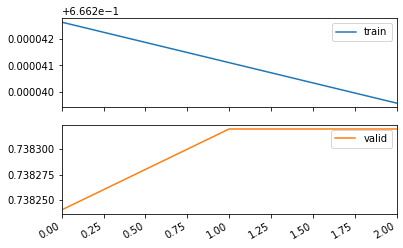

In [2075]:
df.plot(subplots=True)

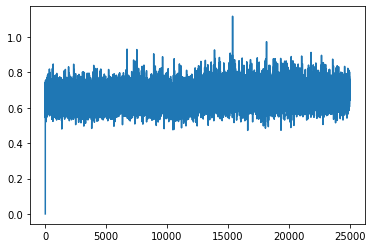

In [2076]:
plt.plot(loss_list)

## Deep NB